Nonlinear Regression  - 1D Data

In [284]:
from ActiveTestingRegression import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')



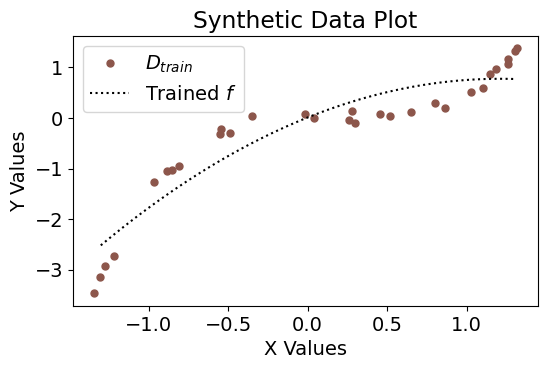

In [290]:
# Set random state
rnd = np.random.RandomState(42)

N = 60 # Number of datapoints
data_max, data_min = 1.4, -1.4 # Assign range of data
len_data = (data_max - data_min) # Get length of data range
data = np.sort(rnd.rand(N) * len_data - len_data/2) # Build and order synthetic data
noise = rnd.randn(N) * 0.1 # Create normally distributed random noise values
target = data ** 3 - 0.5 * data ** 2 + noise # Build polynomial response variable

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size = 0.5, random_state = rnd)

# Trained model f from Conference Paper
reg_learner = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=2, include_bias=False)),
            ("std", StandardScaler()),
            ("linear_regression", Ridge())])

reg_learner.fit(X_train[:,np.newaxis], y_train) # Fit data to get trained model f
y_pred = reg_learner.predict(X_test[:,np.newaxis])

X_new = X_new = np.linspace(-1.3,1.3,100)

# Scatter plot of synthetic data
plt.plot(X_train, y_train, "C5o", markersize=5, label='$D_{train}$')
plt.plot(X_new, reg_learner.predict(X_new[:,np.newaxis]), 'k:', label="Trained $f$")
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Synthetic Data Plot')
plt.legend()
plt.show()

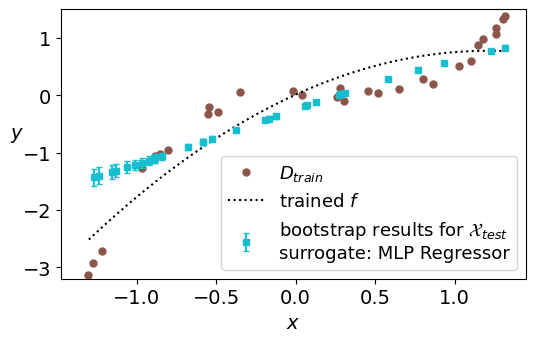

In [286]:
# Use SciKit Learn's MLPRegression NN for trained f model
reg_evaluator = MLPRegressor(hidden_layer_sizes=20)

y_preds = np.zeros([len(X_test), 30]) # initialize prediction storage matrix

for ind in range(30):
    X_boot, y_boot = resample(X_train[:,np.newaxis], y_train, replace=True, random_state=rnd) # resample training data with replacement
    model = reg_evaluator.fit(X_boot,y_boot) # fit model to resampling iteration
    y_preds[:,ind] = reg_evaluator.predict(X_test[:,np.newaxis]) # predict outputs based on model from resampling for the same test values

mean = y_preds.mean(axis=1) # Calculate mean across 30 bootstrap predictions for each test data point
var = y_preds.var(axis=1) # Calculate variance across 30 bootstrap predictions for each test data point

# figure 
plt.rcParams.update({'font.size': 14, "figure.figsize": (6,3.5)})
plt.plot(X_train, y_train, "C5o", markersize=5, label='$D_{train}$')
plt.plot(X_new, reg_learner.predict(X_new[:,np.newaxis]), 'k:', label="trained $f$")
plt.errorbar(X_test, mean, yerr=var, ls='none', marker='s', c="C9",
             markersize=4, capsize=2, label='bootstrap results for $\mathcal{X}_{test}$\nsurrogate: MLP Regressor')

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.legend(fontsize=13)
plt.ylim([-3.2,1.5])
plt.show()

Regression Neural Network Code

In [310]:
import scikeras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping

# Reshape data for NN inputs
X_train2 = X_train.reshape(1,-1)
y_train2 = y_train.reshape(1,-1)
X_test2 = X_test.reshape(1,-1)
y_test2 = y_test.reshape(1,-1)

# Build sequential linear regression NN (able to add dropout layer later)
reg_nn = Sequential(name="RegNN")
reg_nn.add(Dense(1000, input_shape=(30,1), activation='relu')) 
reg_nn.add(Dense(500, activation='relu'))
reg_nn.add(Dense(250, activation='relu'))
reg_nn.add(Dense(1, activation='linear')) # linear activation
reg_nn.add(Flatten())
reg_nn.summary() # NN Summary

# compile the model
reg_nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = reg_nn.fit(X_train2, y_train2,
                    validation_data=(X_test2,y_test2),
                    callbacks=[es],
                    epochs=50,
                    batch_size=10,
                    verbose=1)

Model: "RegNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_445 (Dense)           (None, 30, 1000)          2000      
                                                                 
 dense_446 (Dense)           (None, 30, 500)           500500    
                                                                 
 dense_447 (Dense)           (None, 30, 250)           125250    
                                                                 
 dense_448 (Dense)           (None, 30, 1)             251       
                                                                 
 flatten_30 (Flatten)        (None, 30)                0         
                                                                 
Total params: 628001 (2.40 MB)
Trainable params: 628001 (2.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
1/1 [=========

Bootstrap Regression Neural Network

In [313]:
y_preds2 = np.zeros([len(X_test),30])

## Bootstrap NN
for ind in range(30):
    X_boot, y_boot = resample(X_train2, y_train2, replace=True, random_state=rnd)
    model = reg_nn.fit(X_boot, y_boot,
                    validation_data=(X_test2,y_test2),
                    callbacks=[es],
                    epochs=50,
                    batch_size=10,
                    verbose=1)
    y_preds2[:,ind] = reg_nn.predict(X_test2)


Epoch 1/50
1/1 [==============================] - 0s 66ms/step - loss: 0.0012 - mae: 0.0229 - val_loss: 0.0144 - val_mae: 0.0901
Epoch 2/50
1/1 [==============================] - 0s 47ms/step - loss: 0.0012 - mae: 0.0207 - val_loss: 0.0143 - val_mae: 0.0896
Epoch 3/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0205 - val_loss: 0.0141 - val_mae: 0.0887
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0012 - mae: 0.0235 - val_loss: 0.0145 - val_mae: 0.0901
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 0.0013 - mae: 0.0200 - val_loss: 0.0143 - val_mae: 0.0898
Epoch 6/50
1/1 [==============================] - 0s 18ms/step - loss: 0.0012 - mae: 0.0232 - val_loss: 0.0144 - val_mae: 0.0900
Epoch 7/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0012 - mae: 0.0207 - val_loss: 0.0147 - val_mae: 0.0919
Epoch 8/50
1/1 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0232 - val

array([[-1.33622680e-02, -1.46578616e-02, -1.34450532e-02,
        -1.63061060e-02, -1.03611005e-02, -1.48616340e-02,
        -1.50513630e-02, -1.59130413e-02, -1.60596017e-02,
        -1.77615695e-02, -1.51185077e-02, -1.04024066e-02,
        -1.13075674e-02, -1.93711370e-02, -1.54596977e-02,
        -9.69126821e-03, -1.08855534e-02, -1.73452925e-02,
        -1.63840912e-02, -1.11565925e-02, -1.35689881e-02,
        -1.72398519e-02, -1.36739993e-02, -1.02652078e-02,
        -1.47168646e-02, -2.36497745e-02, -1.40068652e-02,
        -4.71285637e-03, -9.39588808e-03, -7.49453995e-03],
       [-2.30480814e+00, -2.33536482e+00, -2.32523251e+00,
        -2.32843161e+00, -2.34839153e+00, -2.34117389e+00,
        -2.33470988e+00, -2.32982397e+00, -2.34026551e+00,
        -2.32445931e+00, -2.32541347e+00, -2.32874584e+00,
        -2.32274747e+00, -2.34399724e+00, -2.33071756e+00,
        -2.31803179e+00, -2.36746502e+00, -2.35266447e+00,
        -2.33726454e+00, -2.31203413e+00, -2.33660889e+

4/4 [==============================] - 0s 0s/step


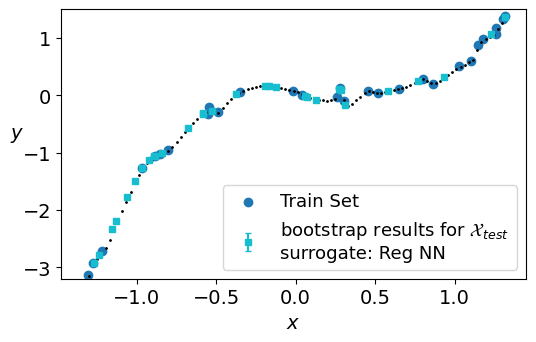

In [316]:

mean2 = y_preds2.mean(axis=1) # Calculate mean across 30 bootstrap predictions for each test data point
var2 = y_preds2.var(axis=1) # Calculate variance across 30 bootstrap predictions for each test data point

# figure 
plt.rcParams.update({'font.size': 14, "figure.figsize": (6,3.5)})
plt.scatter(X_train2, y_train2, label="Train Set")
plt.scatter(X_new, reg_nn.predict(X_new[:,np.newaxis]), s=1, c='k')
plt.errorbar(X_test, mean2, yerr=var2, ls='none', marker='s', c="C9",
             markersize=4, capsize=2, label='bootstrap results for $\mathcal{X}_{test}$\nsurrogate: Reg NN')

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.legend(fontsize=13)
plt.ylim([-3.2,1.5])
plt.show()